In [1]:
! hostname

g01


### The GPU used in the demonstration is NVIDIA GeForce RTX 3080 Ti, which has only 12GB of video memory.

In [2]:
! nvidia-smi

Wed Jul 30 14:43:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:86:00.0 Off |                  N/A |
| 30%   25C    P8             15W /  350W |       1MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# enable autoreload
%load_ext autoreload
%autoreload 2

In [4]:
import os
import sys
import scanpy as sc
import numpy as np
import pandas as pd

import torch
from anndata import AnnData
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [5]:
plt.rcParams['pdf.fonttype'] = 42
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=300,
                     dpi_save=1200,
#                      facecolor='w',
#                      frameon=False, # frameon=True
#                      figsize=(4,4)
                    ) 
%config InlineBackend.figure_format='retina'
%matplotlib inline

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [6]:
# import cellniche as cn

sys.path.append('/share/home/liangzhongming/phd_code/530/CellNiche/release')
import cellniche as cn

### Configuration Files

In [7]:
! cat ../configs/cortex.yaml

# ============================================================
#  DATA & PRE‑PROCESSING
# ============================================================
data_path: "../data/"               # Root directory of your input data
dataset: "osmFISH_SScortex"         # Folder / file prefix of the dataset
phenoLabels: "ClusterName"          # Cell‑level phenotype label in .obs
nicheLabels: "Region"               # Ground‑truth micro‑environment label in .obs
embedding_type: "pheno_expr"        # Options: "pheno_expr" | "pheno" | "expr"
                                    #   pheno_expr : use both phenotype & expression
                                    #   pheno      : use phenotype only
                                    #   expr       : use expression only

hvg: false                          # Select highly‑variable genes (HVGs) or not
n_hvg: 256                          # Number of HVGs if hvg == true

# ============================================================
#  GRAPH CONSTRUCTION (C

In [10]:
cortex = cn.cli(["--config", "../configs/cortex.yaml"])

17:07:32 INFO: Seed: 3268
17:07:32 INFO: Using device: cuda
17:07:32 INFO: Average number of neighbors per node: 30.021396396396398
17:07:32 INFO: Loaded osmFISH_SScortex: 5328 nodes, 159954 edges, 32 features
17:07:33 INFO: loading_time: 0.94s
17:07:35 INFO: Epoch 1 Step 0001 contrast_loss=8.3596, recon_loss=0.0000
17:07:35 INFO: Epoch 1 Step 0002 contrast_loss=8.1943, recon_loss=0.0000
17:07:35 INFO: Epoch 1 Step 0003 contrast_loss=8.0826, recon_loss=0.0000
17:07:35 INFO: Epoch 1 Step 0004 contrast_loss=8.0214, recon_loss=0.0000
17:07:35 INFO: Epoch 1 Step 0005 contrast_loss=7.9694, recon_loss=0.0000
17:07:35 INFO: Epoch 1 Step 0006 contrast_loss=7.9408, recon_loss=0.0000
17:07:35 INFO: Epoch 1 Step 0007 contrast_loss=7.8995, recon_loss=0.0000
17:07:35 INFO: Epoch 1 Step 0008 contrast_loss=7.8697, recon_loss=0.0000
17:07:36 INFO: Epoch 1 Step 0009 contrast_loss=7.8508, recon_loss=0.0000
17:07:36 INFO: Epoch 1 Step 0010 contrast_loss=7.8367, recon_loss=0.0000
17:07:38 INFO: Epoch 2 St

In [9]:
cortex

AnnData object with n_obs × n_vars = 5328 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'kmeans'
    var: 'gene_names'
    obsm: 'spatial', 'CellNiche'

In [69]:
# TO MATCH PAPER FIGURES
adata = sc.read_h5ad("/share/home/liangzhongming/phd_code/530/CellNiche/data/cortex_CellNiche.h5ad")

In [72]:
adata

AnnData object with n_obs × n_vars = 5328 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'CellNiche_KMeans_matched', 'aligned_CellNiche_KMeans', 'CellNiche_KMeans_pheno', 'aligned_CellNiche_KMeans_pheno_name', 'CellNiche_KMeans_expr', 'aligned_CellNiche_KMeans_expr_name', 'CellNiche_KMeans_decoder', 'aligned_CellNiche_KMeans_decoder_name'
    var: 'gene_names'
    obsm: 'CellNiche_decoder', 'CellNiche_expr', 'CellNiche_pheno', 'spatial'

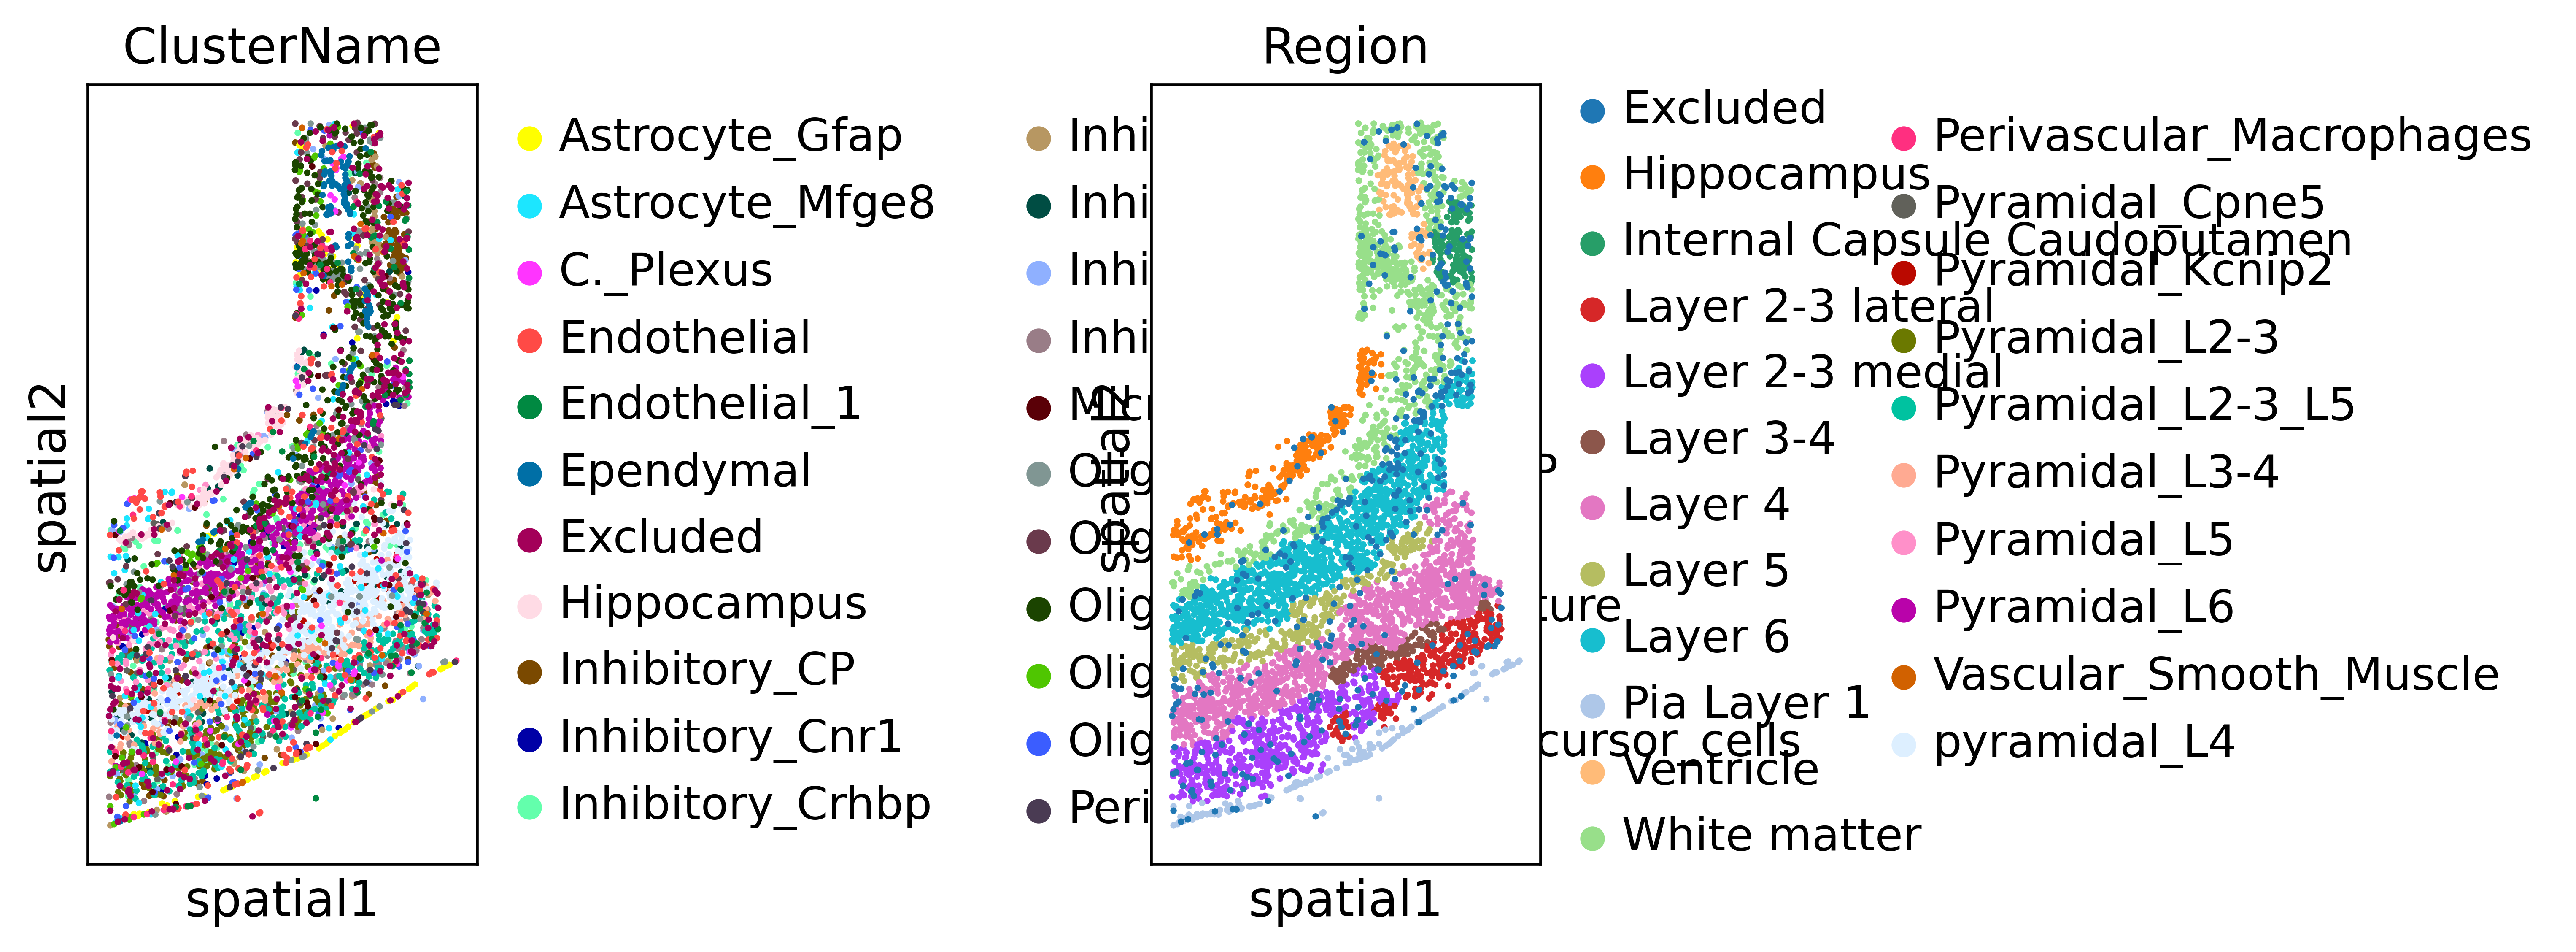

In [76]:
sc.pl.spatial(
    adata, 
    color=['ClusterName', 
           'Region', 
          ], 
    spot_size=450,
 )

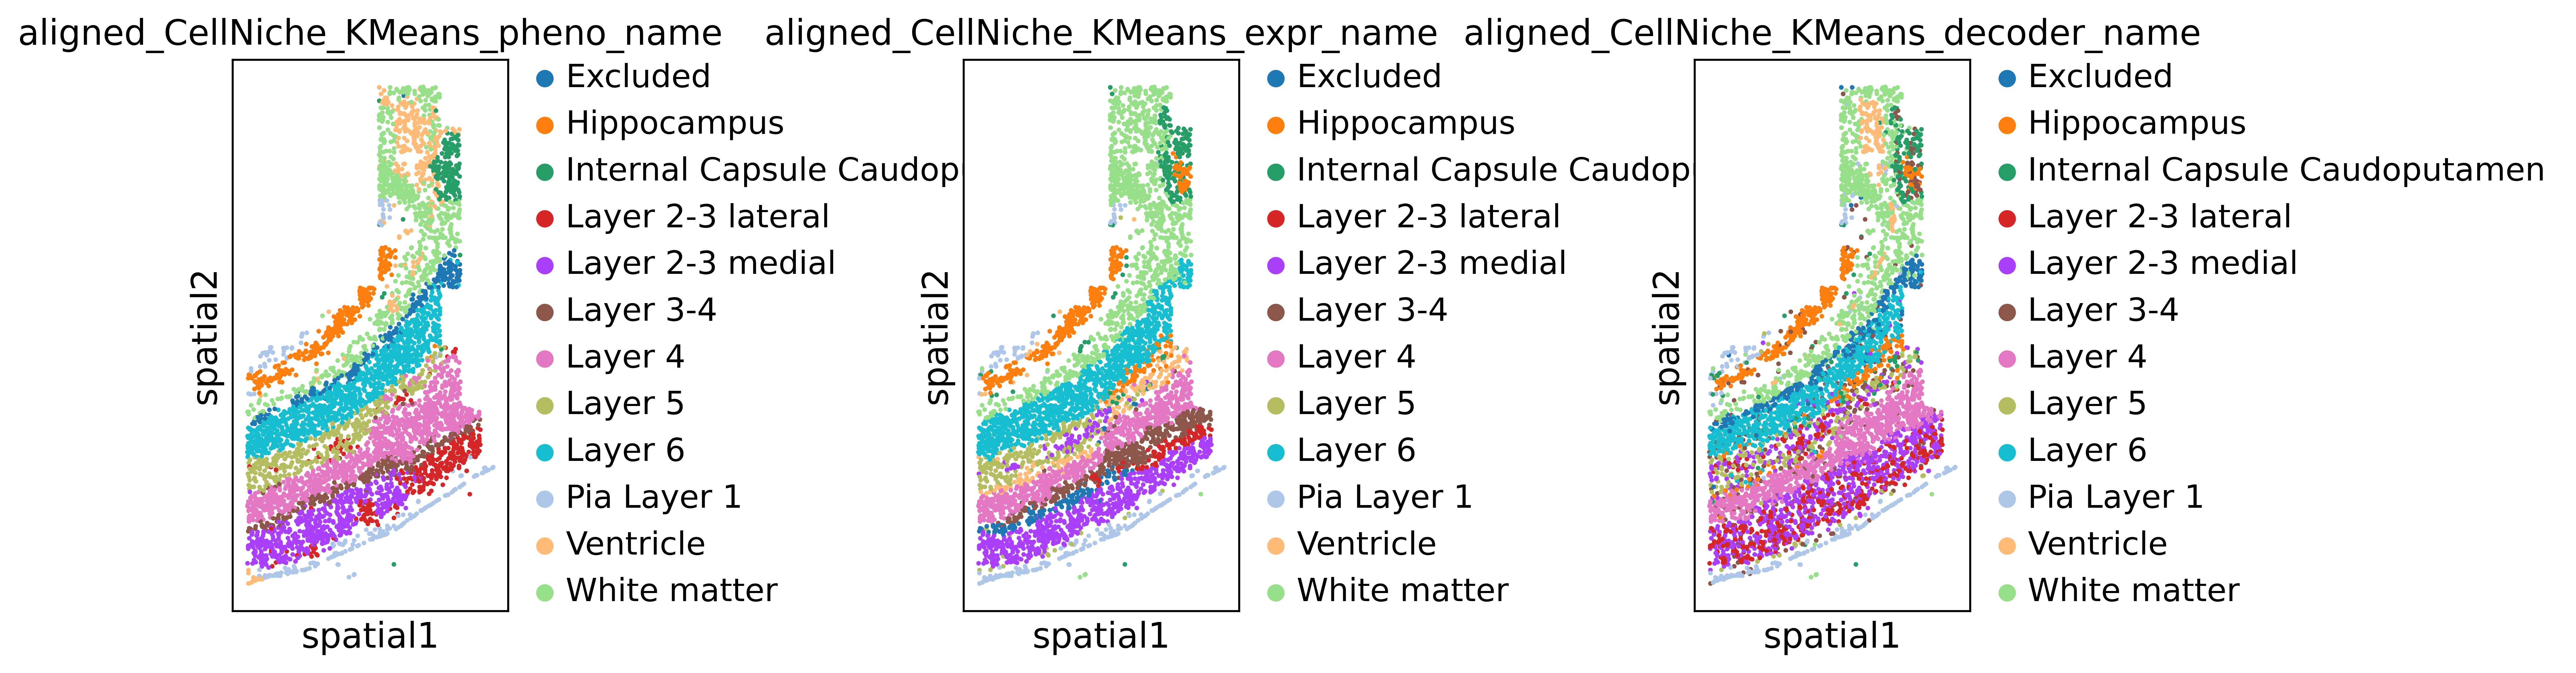

In [77]:
sc.pl.spatial(
    adata, 
    color=[
           'aligned_CellNiche_KMeans_pheno_name', 
           'aligned_CellNiche_KMeans_expr_name', 
           'aligned_CellNiche_KMeans_decoder_name',
          ], 
    spot_size=450,
 )

In [80]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    normalized_mutual_info_score, adjusted_rand_score, f1_score,
    adjusted_mutual_info_score, homogeneity_score
)

true_labels = adata.obs['Region'].astype('category')
# feature_keys  = ['CellNiche_pheno', 'CellNiche_expr', 'CellNiche_decoder']
pred_keys     = ['CellNiche_KMeans_pheno',
                 'CellNiche_KMeans_expr',
                 'CellNiche_KMeans_decoder']
matched_keys  = ['aligned_' + k + '_name' for k in pred_keys]


metrics_dict = {}
for feat_key, pred_key, match_key, tag in zip(
        feature_keys, pred_keys, matched_keys,
        ['CellNiche_pheno', 'CellNiche_expr', 'CellNiche_decoder']):
#     feature = adata.obsm[feat_key]
    aligned_labels = adata.obs[match_key].astype('category')

    acc         = (aligned_labels == true_labels).mean()
    nmi         = normalized_mutual_info_score(true_labels, aligned_labels)
    adjscore    = adjusted_rand_score(true_labels, aligned_labels)
    f1_macro    = f1_score(true_labels, aligned_labels, average='macro')
    f1_micro    = f1_score(true_labels, aligned_labels, average='micro')
    ami         = adjusted_mutual_info_score(true_labels, aligned_labels)
    homogeneity = homogeneity_score(true_labels, aligned_labels)

    metrics_dict[tag] = {
        'Acc'            : acc,
        'NMI'            : nmi,
        'AMI'            : ami,
        'ARI'            : adjscore,
        'F1 Macro'       : f1_macro,
        'F1 Micro'       : f1_micro,
        'Homogeneity score': homogeneity
    }

In [81]:
metrics_dict

{'CellNiche_pheno': {'Acc': 0.7691441441441441,
  'NMI': 0.6824416499410031,
  'AMI': 0.6808160589544935,
  'ARI': 0.6635901536678253,
  'F1 Macro': 0.7109628600719241,
  'F1 Micro': 0.7691441441441441,
  'Homogeneity score': 0.6966113299866665},
 'CellNiche_expr': {'Acc': 0.6493993993993994,
  'NMI': 0.6226450375917534,
  'AMI': 0.6206721812945649,
  'ARI': 0.5608740253908532,
  'F1 Macro': 0.521061051764481,
  'F1 Micro': 0.6493993993993994,
  'Homogeneity score': 0.6251516357834213},
 'CellNiche_decoder': {'Acc': 0.5829579579579579,
  'NMI': 0.5107563417427279,
  'AMI': 0.5082498822458198,
  'ARI': 0.4546661363021853,
  'F1 Macro': 0.49394005550742115,
  'F1 Micro': 0.5829579579579579,
  'Homogeneity score': 0.5216307111223883}}